In [1]:
"""Functions for plotting tca decomp."""
import os
import flow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensortools as tt
import seaborn as sns
import pandas as pd
from copy import deepcopy
from cascade import df
from cascade import tca
from cascade import paths

In [38]:
# singleday_factors_annotated(
mouse='OA27'
trace_type='zscore_day'
method='ncp_bcd'
cs=''
warp=False
word='convinced'
extra_col=4
alpha=0.6
plot_running=True
filetype='pdf'
scale_y=False
verbose=False

pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}

days = flow.DateSorter.frommeta(mice=[mouse], tags=None)

cell_sz = np.shape(df.get_xdaymap(mouse))

cell_map = np.zeros(cell_sz)
cell_map[:] = np.nan
cell_map_w = deepcopy(cell_map)
for d, day1 in enumerate(days):
    
#     # all cells
#     d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    
#     # all runs
#     d1_runs = day1.runs()
    
#     # get all trace2p
#     for run in d1_runs:
#         t2p = run.trace2p()
        
    # load dir
    load_dir = paths.tca_path(mouse, 'single',
                              pars=pars, word=word)
    tensor_path = os.path.join(load_dir, str(day1.mouse)
                               + '_' + str(day1.date)
                               + '_single_decomp_'
                               + str(trace_type) + '.npy')
    input_tensor_path = os.path.join(load_dir, str(day1.mouse)
                                     + '_' + str(day1.date)
                                     + '_single_tensor_'
                                     + str(trace_type) + '.npy')
    input_ids_path = os.path.join(load_dir, str(day1.mouse)
                                  + '_' + str(day1.date)
                                  + '_single_ids_'
                                  + str(trace_type) + '.npy')
    meta_path = os.path.join(load_dir, str(day1.mouse)
                             + '_' + str(day1.date)
                             + '_df_single_meta.pkl')

    # load your data
    ensemble = np.load(tensor_path)
    ensemble = ensemble.item()
    ids = np.load(input_ids_path)

    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = tca._sortfactors(ensemble[method])

    cell_ids = {}  # keys are rank
    cell_clusters = {}
    itr_num = 0  # use only best iteration of TCA, index 0
    for k in sort_ensemble.results.keys():
        # factors are already sorted, so these will define
        # clusters, no need to sort again
        factors = sort_ensemble.results[k][itr_num].factors[0]
        max_fac = np.argmax(factors, axis=1)
        cell_clusters[k] = max_fac
        cell_ids[k] = ids[my_sorts[k-1]]
    
    cell_weights = {}
    for k in sort_ensemble.results.keys():
        factors = sort_ensemble.results[k][itr_num].factors[0]
        best_fac = np.zeros(np.shape(factors[:,0]))
        for c in range(np.shape(factors)[1]):
            fac_vec = deepcopy(factors[:, c])
            fac_vec[cell_clusters[k] != c] = 0
            best_fac += fac_vec
        cell_weights[k] = best_fac
    
    match_rank = 6
    for cell in range(len(cell_clusters[match_rank])): # cell ids are 1 indexed
        if cell_weights[match_rank][cell] < 0.3:
            continue
        cell_idx = cell_ids[match_rank][cell]
        cell_map[cell_idx, d] = cell_clusters[match_rank][cell]
        cell_map_w[cell_idx, d] = cell_weights[match_rank][cell]


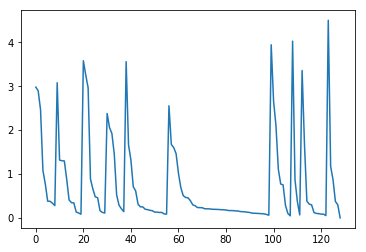

In [40]:
plt.plot(cell_weights[10])

In [11]:
duds = np.sum(np.isnan(cell_map), axis=1) == 35
filt_map0 = cell_map[~duds,:]
filt1 = filt_map[:,0] == 0
filt2 = filt_map[:,1] == 2
filt_map = filt_map[filt1,:]

In [ ]:
np.isnan(np.unique(filt_map0[:,0]))

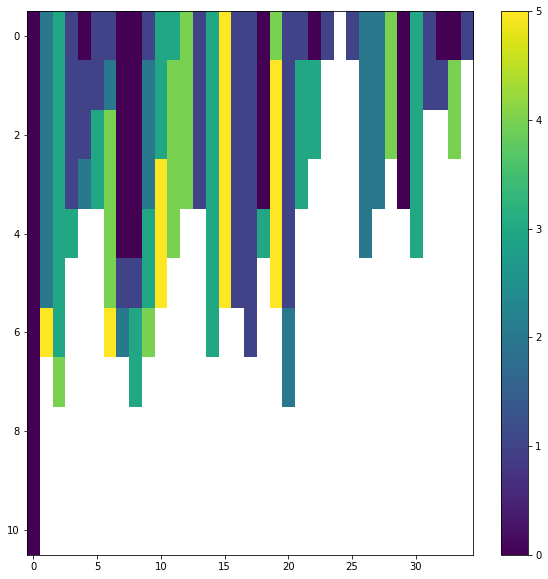

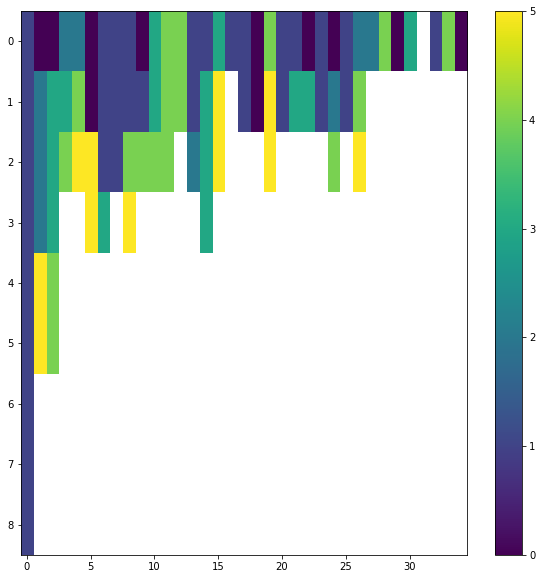

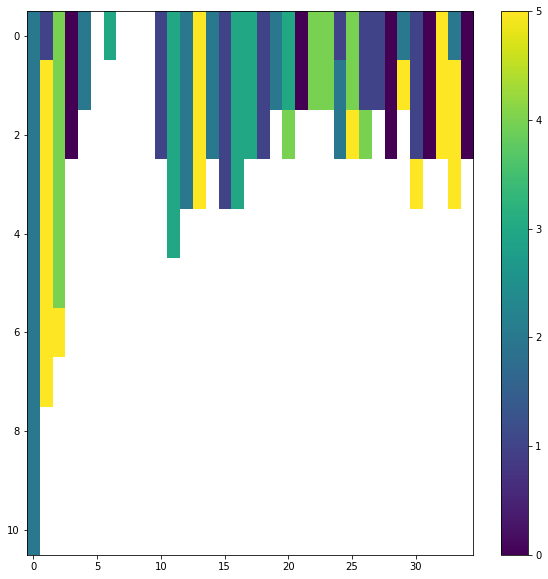

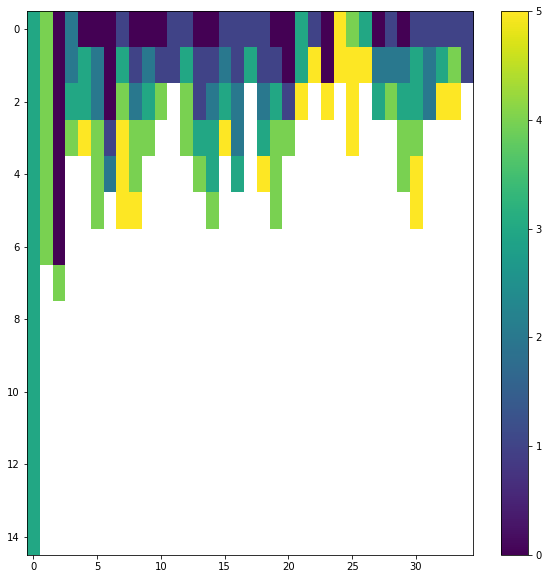

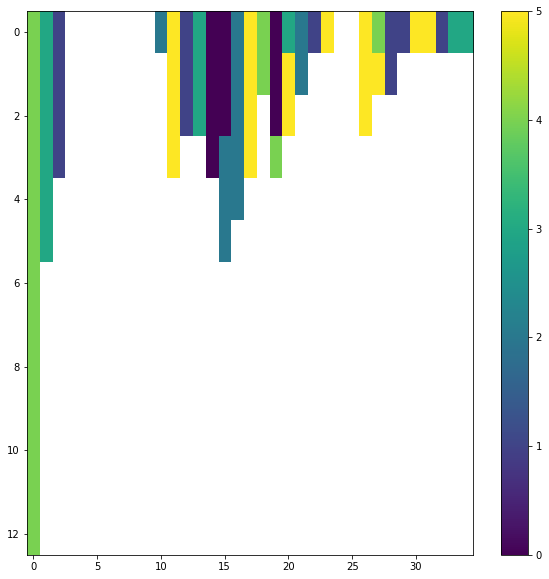

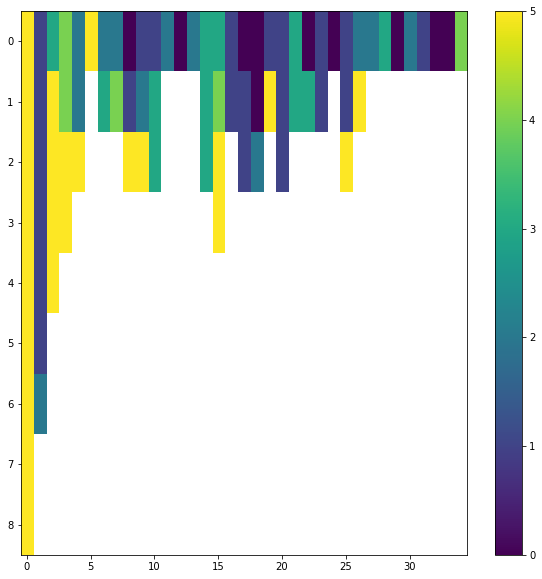

In [39]:
filt_map0 = cell_map[~duds,:]
for n in np.unique(filt_map0[:,0])[~np.isnan(np.unique(filt_map0[:,0]))]:
    filt_map = cell_map[~duds,:]
#     w_map = cell_map_w[~duds,:]
#     filt_map = filt_map[w_map > 0.3]
    filt1 = filt_map[:,0] == n
    filt_map = filt_map[filt1,:]
    sorter = np.argsort(np.sum(np.isnan(filt_map), axis=1))
    plt.figure(figsize=(10,10))
    plt.imshow(np.sort(filt_map[sorter,:], axis=0), aspect='auto')
    plt.colorbar()